In [ ]:
!wget -r -N -c -np "https://physionet.org/files/mitdb/1.0.0/" -P "/content/drive/My Drive/MIT-BIH/"

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-03-11 09:01:11 (851 MB/s) - ‘/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-03-11 09:01:11--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   453KB/s    in 4.1s    

2025-03-11 09:01:15 (459 KB/s) - ‘/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-03-11 09:01:15--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing 

In [ ]:
!ls "/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/"

100.atr    105.atr  111.atr  116.dat  122.atr  202.dat	209.at_  214.xws  221.xws  231.xws
100.dat    105.dat  111.dat  116.hea  122.dat  202.hea	209.atr  215.at_  222.at_  232.atr
100.hea    105.hea  111.hea  116.xws  122.hea  202.xws	209.dat  215.atr  222.atr  232.dat
100.xws    105.xws  111.xws  117.at_  122.xws  203.at-	209.hea  215.dat  222.dat  232.hea
101.atr    106.atr  112.atr  117.atr  123.atr  203.at_	209.xws  215.hea  222.hea  232.xws
101.dat    106.dat  112.dat  117.dat  123.dat  203.atr	210.atr  215.xws  222.xws  233.atr
101.hea    106.hea  112.hea  117.hea  123.hea  203.dat	210.dat  217.atr  223.atr  233.dat
101.xws    106.xws  112.xws  117.xws  123.xws  203.hea	210.hea  217.dat  223.dat  233.hea
102-0.atr  107.atr  113.atr  118.atr  124.atr  203.xws	210.xws  217.hea  223.hea  233.xws
102.atr    107.dat  113.dat  118.dat  124.dat  205.atr	212.atr  217.xws  223.xws  234.atr
102.dat    107.hea  113.hea  118.hea  124.hea  205.dat	212.dat  219.atr  228.atr  234.dat
102.hea   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

base_path = '/content/drive/My Drive/MIT-BIH/physionet.org/files/mitdb/1.0.0/'
records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
           '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
           '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
           '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
           '222', '223', '228', '230', '231', '232', '233', '234']

# Function to map beat annotations to 5 classes (AAMI standard)
def map_beat_to_class(symbol):
    # AAMI classes: N (0), S (1), V (2), F (3), Q (4)
    if symbol in ['N', 'L', 'R', 'e', 'j']:  # Normal and related
        return 0
    elif symbol in ['A', 'a', 'J', 'S']:  # Supraventricular ectopic
        return 1
    elif symbol in ['V', 'E']:  # Ventricular ectopic
        return 2
    elif symbol == 'F':  # Fusion
        return 3
    elif symbol in ['/', 'Q', 'f']:  # Paced/Unknown
        return 4
    else:
        return -1  # Ignore other symbols (e.g., noise)

# Load and segment beats
X_ecg = []
X_rr = []
y = []
window_size = 187  # Same as Kaggle dataset
half_window = window_size // 2

for record_id in records:
    # Load the record
    record = wfdb.rdrecord(base_path + record_id)
    annotation = wfdb.rdann(base_path + record_id, 'atr')

    # Get the ECG signal (use first channel, typically Lead II)
    signal = record.p_signal[:, 0]  # Shape: (num_samples,)

    # Get R-peak locations and symbols
    r_peaks = annotation.sample  # Sample indices of R-peaks
    symbols = annotation.symbol  # Beat types

    # Segment beats around R-peaks
    for i in range(len(r_peaks)):
        label = map_beat_to_class(symbols[i])
        if label == -1:  # Skip non-beat annotations
            continue

        r_peak = r_peaks[i]
        # Ensure the window fits within signal bounds
        start = r_peak - half_window
        end = r_peak + half_window + 1
        if start < 0 or end > len(signal):
            continue

        # Extract the beat (187 samples)
        beat = signal[start:end]  # Shape: (187,)

        # Compute RR interval (time between consecutive R-peaks)
        if i > 0:
            rr_interval = (r_peaks[i] - r_peaks[i-1]) / 360  # Convert to seconds (360 Hz)
        else:
            rr_interval = 0  # First beat, no previous R-peak

        X_ecg.append(beat)
        X_rr.append(rr_interval)
        y.append(label)

# Convert to numpy arrays
X_ecg = np.array(X_ecg)  # Shape: (num_beats, 187)
X_rr = np.array(X_rr)    # Shape: (num_beats,)
y = np.array(y)          # Shape: (num_beats,)

# Normalize ECG signals
scaler = MinMaxScaler()
X_ecg = scaler.fit_transform(X_ecg)

# Reshape for CNN
X_ecg = X_ecg.reshape((X_ecg.shape[0], X_ecg.shape[1], 1))  # Shape: (num_beats, 187, 1)
X_rr = X_rr.reshape(-1, 1)  # Shape: (num_beats, 1)

# Convert labels to categorical (5 classes)
y = to_categorical(y, num_classes=5)

print("X_ecg shape:", X_ecg.shape)
print("X_rr shape:", X_rr.shape)
print("y shape:", y.shape)


X_ecg shape: (109468, 187, 1)
X_rr shape: (109468, 1)
y shape: (109468, 5)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_ecg_train, X_ecg_test, X_rr_train, X_rr_test, y_train, y_test = train_test_split(
    X_ecg, X_rr, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# Verify shapes
print("X_ecg_train shape:", X_ecg_train.shape)
print("X_ecg_test shape:", X_ecg_test.shape)
print("X_rr_train shape:", X_rr_train.shape)
print("X_rr_test shape:", X_rr_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_ecg_train shape: (87574, 187, 1)
X_ecg_test shape: (21894, 187, 1)
X_rr_train shape: (87574, 1)
X_rr_test shape: (21894, 1)
y_train shape: (87574, 5)
y_test shape: (21894, 5)


In [ ]:
np.save('/content/drive/My Drive/MIT-BIH/y_train.npy', y_train)

In [ ]:
def augment_data(X_ecg, X_rr, y, target_class, num_samples, noise_factor=0.01):
    idx = np.where(np.argmax(y, axis=1) == target_class)[0]
    X_ecg_class = X_ecg[idx]
    X_rr_class = X_rr[idx]

    X_ecg_augmented = []
    X_rr_augmented = []
    for _ in range(num_samples):
        sample_idx = np.random.randint(len(X_ecg_class))
        ecg_sample = X_ecg_class[sample_idx]
        rr_sample = X_rr_class[sample_idx]

        noise = np.random.normal(0, noise_factor, ecg_sample.shape)
        ecg_augmented = ecg_sample + noise

        rr_noise = np.random.normal(0, noise_factor, rr_sample.shape)
        rr_augmented = rr_sample + rr_noise

        X_ecg_augmented.append(ecg_augmented)
        X_rr_augmented.append(rr_augmented)

    X_ecg_augmented = np.array(X_ecg_augmented)
    X_rr_augmented = np.array(X_rr_augmented)

    y_augmented = np.zeros((num_samples, y.shape[1]))
    y_augmented[:, target_class] = 1

    return X_ecg_augmented, X_rr_augmented, y_augmented

# Check class distribution
print("Class Distribution (Training):", np.bincount(np.argmax(y_train, axis=1)))

# Augment minority classes (adjust num_samples based on distribution)
X_ecg_aug_1, X_rr_aug_1, y_aug_1 = augment_data(X_ecg_train, X_rr_train, y_train, target_class=1, num_samples=2000)
X_ecg_aug_2, X_rr_aug_2, y_aug_2 = augment_data(X_ecg_train, X_rr_train, y_train, target_class=2, num_samples=2000)
X_ecg_aug_4, X_rr_aug_4, y_aug_4 = augment_data(X_ecg_train, X_rr_train, y_train, target_class=4, num_samples=2000)

# Combine original and augmented data
X_ecg_train_aug = np.concatenate([X_ecg_train, X_ecg_aug_1, X_ecg_aug_2, X_ecg_aug_4], axis=0)
X_rr_train_aug = np.concatenate([X_rr_train, X_rr_aug_1, X_rr_aug_2, X_rr_aug_4], axis=0)
y_train_aug = np.concatenate([y_train, y_aug_1, y_aug_2, y_aug_4], axis=0)

# Verify shapes
print("X_ecg_train_aug shape:", X_ecg_train_aug.shape)
print("X_rr_train_aug shape:", X_rr_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)

Class Distribution (Training): [72486  2225  5788   642  6433]
X_ecg_train_aug shape: (93574, 187, 1)
X_rr_train_aug shape: (93574, 1)
y_train_aug shape: (93574, 5)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_ecg_train = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy')
y_train = np.load('/content/drive/My Drive/MIT-BIH/y_train_aug.npy')
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
y_test = np.load('/content/drive/My Drive/MIT-BIH/y_test.npy')

In [3]:
# Combine train and test data for visualization
X_ecg = np.concatenate([X_ecg_train, X_ecg_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
y_labels = np.argmax(y, axis=1)

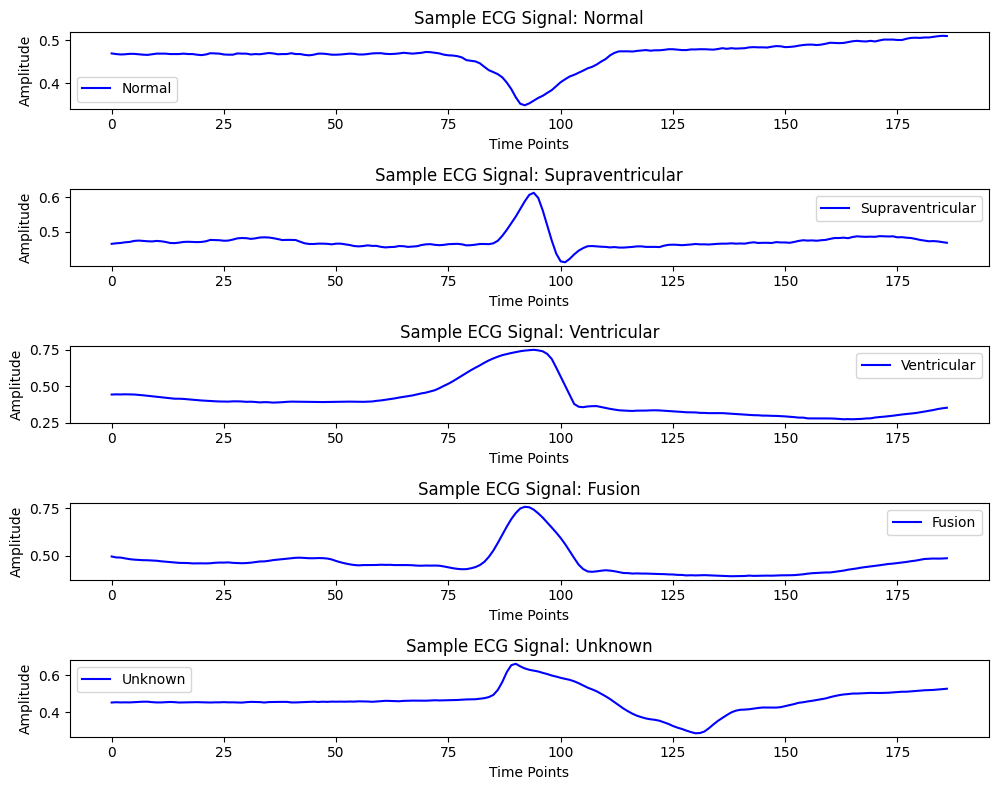

In [5]:
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
plt.figure(figsize=(10, 8))  # Set figure size for better visibility
for i in range(5):
    # Find the first sample for each class
    idx = np.where(y_labels == i)[0][0]
    ecg_signal = X_ecg[idx, :, 0]
    plt.subplot(5, 1, i+1)
    plt.plot(ecg_signal, label=class_names[i], color='blue')
    plt.title(f'Sample ECG Signal: {class_names[i]}')
    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()
plt.savefig('ecg_samples.png')
plt.show()

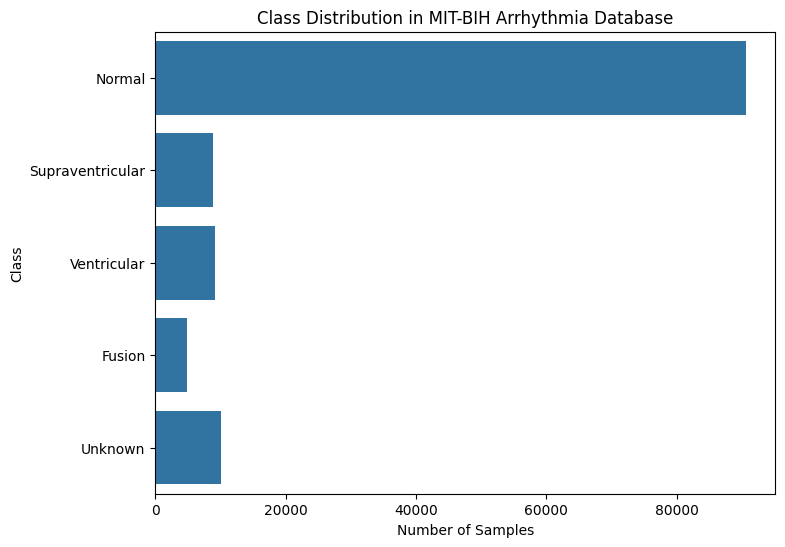

In [7]:
class_counts = [np.sum(y_labels == i) for i in range(5)]
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts, y=class_names)
plt.title('Class Distribution in MIT-BIH Arrhythmia Database')
plt.xlabel('Number of Samples')
plt.ylabel('Class')
plt.savefig('class_distribution.png')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate

In [ ]:
# Define the model
ecg_input = Input(shape=(187, 1), name='ecg_input')
x = Conv1D(32, 5, activation='relu')(ecg_input)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
ecg_output = Dense(128, activation='relu')(x)

rr_input = Input(shape=(1,), name='rr_input')
y = Dense(16, activation='relu')(rr_input)
rr_output = Dense(16, activation='relu')(y)

combined = Concatenate()([ecg_output, rr_output])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(5, activation='softmax')(z)

model = Model(inputs=[ecg_input, rr_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train with augmented data
history = model.fit(
    [X_ecg_train_aug, X_rr_train_aug], y_train_aug,
    epochs=20,
    batch_size=32,
    validation_data=([X_ecg_test, X_rr_test], y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8366 - loss: 0.5706 - val_accuracy: 0.9599 - val_loss: 0.1410
Epoch 2/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9451 - loss: 0.1851 - val_accuracy: 0.9698 - val_loss: 0.1008
Epoch 3/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9611 - loss: 0.1332 - val_accuracy: 0.9729 - val_loss: 0.1027
Epoch 4/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9673 - loss: 0.1095 - val_accuracy: 0.9785 - val_loss: 0.0835
Epoch 5/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9727 - loss: 0.0941 - val_accuracy: 0.9802 - val_loss: 0.0650
Epoch 6/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9742 - loss: 0.0861 - val_accuracy: 0.9836 - val_loss: 0.0583
Epoch 7/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9761 - loss: 0.0784 - val_accuracy: 0.9839 - val_loss: 0.0570
Epoch 8/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9783 - loss: 0

In [ ]:
# Evaluate
test_loss, test_accuracy = model.evaluate([X_ecg_test, X_rr_test], y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9856 - loss: 0.0532
Test Accuracy: 0.9862
Test Loss: 0.0520


In [ ]:
# Class distribution
print("Class Distribution (Augmented Training):", np.bincount(np.argmax(y_train_aug, axis=1)))
print("Class Distribution (Test):", np.bincount(np.argmax(y_test, axis=1)))

Class Distribution (Augmented Training): [72486  4225  7788   642  8433]
Class Distribution (Test): [18122   556  1447   160  1609]


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


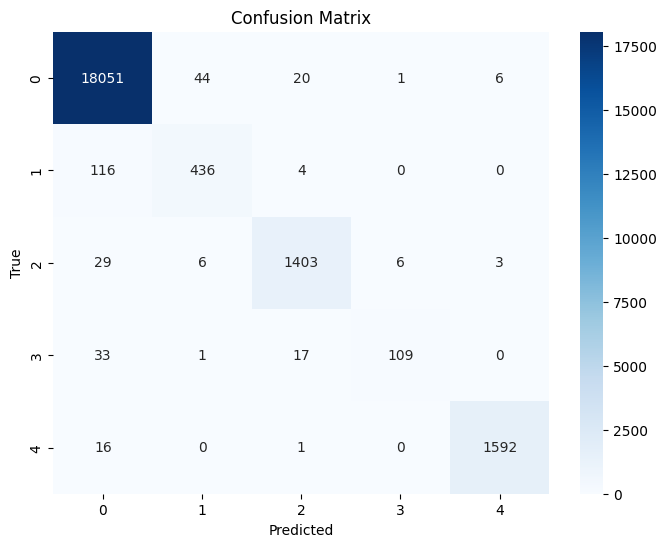

                  precision    recall  f1-score   support

          Normal       0.99      1.00      0.99     18122
Supraventricular       0.90      0.78      0.84       556
     Ventricular       0.97      0.97      0.97      1447
          Fusion       0.94      0.68      0.79       160
         Unknown       0.99      0.99      0.99      1609

        accuracy                           0.99     21894
       macro avg       0.96      0.88      0.92     21894
    weighted avg       0.99      0.99      0.99     21894



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict([X_ecg_test, X_rr_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_test_classes, y_pred_classes, target_names=['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Retrain with class weights
history = model.fit(
    [X_ecg_train_aug, X_rr_train_aug], y_train_aug,
    epochs=20,
    batch_size=32,
    validation_data=([X_ecg_test, X_rr_test], y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9070 - loss: 0.2793 - val_accuracy: 0.8609 - val_loss: 0.3865
Epoch 2/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9185 - loss: 0.2026 - val_accuracy: 0.9502 - val_loss: 0.1732
Epoch 3/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9210 - loss: 0.1937 - val_accuracy: 0.9610 - val_loss: 0.1256
Epoch 4/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9245 - loss: 0.1525 - val_accuracy: 0.9234 - val_loss: 0.2304
Epoch 5/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9204 - loss: 0.1613 - val_accuracy: 0.9505 - val_loss: 0.1545
Epoch 6/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9279 - loss: 0.1514 - val_accuracy: 0.9279 - val_loss: 0.2204
Epoch 7/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9275 - loss: 0.1528 - val_accuracy: 0.9137 - val_loss: 0.3167
Epoch 8/20
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9231 - loss: 0

In [ ]:
# Add more samples to Supraventricular (class 1) and Fusion (class 3)
X_ecg_aug_1, X_rr_aug_1, y_aug_1 = augment_data(X_ecg_train, X_rr_train, y_train, target_class=1, num_samples=4000)
X_ecg_aug_3, X_rr_aug_3, y_aug_3 = augment_data(X_ecg_train, X_rr_train, y_train, target_class=3, num_samples=4000)

# Combine with existing augmented data
X_ecg_train_aug = np.concatenate([X_ecg_train_aug, X_ecg_aug_1, X_ecg_aug_3], axis=0)
X_rr_train_aug = np.concatenate([X_rr_train_aug, X_rr_aug_1, X_rr_aug_3], axis=0)
y_train_aug = np.concatenate([y_train_aug, y_aug_1, y_aug_3], axis=0)

# Retrain
history = model.fit(
    [X_ecg_train_aug, X_rr_train_aug], y_train_aug,
    epochs=20,
    batch_size=32,
    validation_data=([X_ecg_test, X_rr_test], y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9731 - loss: 0.0836 - val_accuracy: 0.9839 - val_loss: 0.0615
Epoch 2/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9791 - loss: 0.0626 - val_accuracy: 0.9846 - val_loss: 0.0619
Epoch 3/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9817 - loss: 0.0564 - val_accuracy: 0.9842 - val_loss: 0.0651
Epoch 4/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9829 - loss: 0.0554 - val_accuracy: 0.9860 - val_loss: 0.0534
Epoch 5/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9842 - loss: 0.0486 - val_accuracy: 0.9860 - val_loss: 0.0605
Epoch 6/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9843 - loss: 0.0509 - val_accuracy: 0.9852 - val_loss: 0.0630
Epoch 7/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9853 - loss: 0.0466 - val_accuracy: 0.9862 - val_loss: 0.0553
Epoch 8/20
3175/3175 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9863 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate([X_ecg_test, X_rr_test], y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9868 - loss: 0.0518
Test Accuracy: 0.9860
Test Loss: 0.0534


In [ ]:
y_pred = model.predict([X_ecg_test, X_rr_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


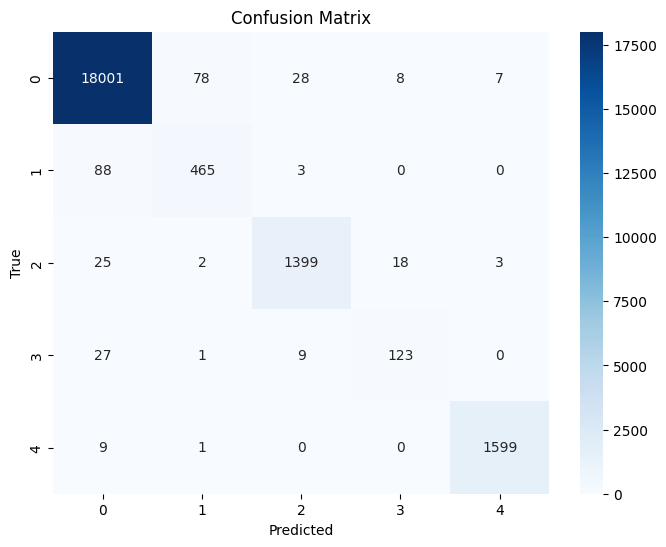

                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99     18122
Supraventricular       0.85      0.84      0.84       556
     Ventricular       0.97      0.97      0.97      1447
          Fusion       0.83      0.77      0.80       160
         Unknown       0.99      0.99      0.99      1609

        accuracy                           0.99     21894
       macro avg       0.93      0.91      0.92     21894
    weighted avg       0.99      0.99      0.99     21894



In [ ]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test_classes, y_pred_classes, target_names=['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']))

In [ ]:
model.save('/content/drive/My Drive/MIT-BIH/saved_model/final_model.h5')
np.save('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy', X_ecg_train_aug)
np.save('/content/drive/My Drive/MIT-BIH/X_rr_train_aug.npy', X_rr_train_aug)
np.save('/content/drive/My Drive/MIT-BIH/y_train_aug.npy', y_train_aug)
np.save('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy', X_ecg_test)
np.save('/content/drive/My Drive/MIT-BIH/X_rr_test.npy', X_rr_test)
np.save('/content/drive/My Drive/MIT-BIH/y_test.npy', y_test)

In [ ]:
import numpy as np

# Flatten ECG signals
X_ecg_train_flat = X_ecg_train_aug.reshape(X_ecg_train_aug.shape[0], -1)
X_ecg_test_flat = X_ecg_test.reshape(X_ecg_test.shape[0], -1)

# Combine ECG and RR features
X_train_rf = np.hstack([X_ecg_train_flat, X_rr_train_aug])
X_test_rf = np.hstack([X_ecg_test_flat, X_rr_test])

# Convert labels back to 1D
y_train_rf = np.argmax(y_train_aug, axis=1)
y_test_rf = np.argmax(y_test, axis=1)

# Verify shapes
print("X_train_rf shape:", X_train_rf.shape)
print("X_test_rf shape:", X_test_rf.shape)
print("y_train_rf shape:", y_train_rf.shape)
print("y_test_rf shape:", y_test_rf.shape)

X_train_rf shape: (101574, 188)
X_test_rf shape: (21894, 188)
y_train_rf shape: (101574,)
y_test_rf shape: (21894,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test_rf)

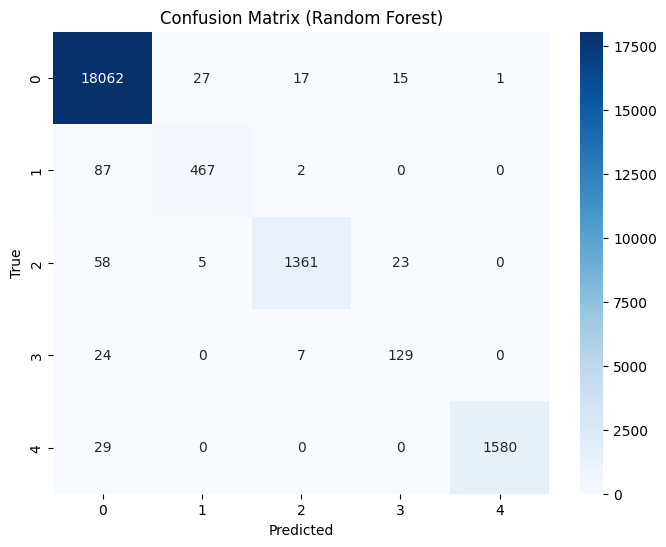

In [ ]:
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']))

Random Forest Classification Report:
                  precision    recall  f1-score   support

          Normal       0.99      1.00      0.99     18122
Supraventricular       0.94      0.84      0.89       556
     Ventricular       0.98      0.94      0.96      1447
          Fusion       0.77      0.81      0.79       160
         Unknown       1.00      0.98      0.99      1609

        accuracy                           0.99     21894
       macro avg       0.94      0.91      0.92     21894
    weighted avg       0.99      0.99      0.99     21894



In [ ]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, '/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model.pkl')

['/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model.pkl']

In [ ]:
import joblib
import numpy as np

In [ ]:
rf_model = joblib.load('/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model.pkl')

In [ ]:
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
X_rr_test = np.load('/content/drive/My Drive/MIT-BIH/X_rr_test.npy')

In [ ]:
X_ecg_test_flat = X_ecg_test.reshape(X_ecg_test.shape[0], -1)
X_test_rf = np.hstack([X_ecg_test_flat, X_rr_test])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Extract feature importance from the Random Forest model
feature_importance = rf_model.feature_importances_

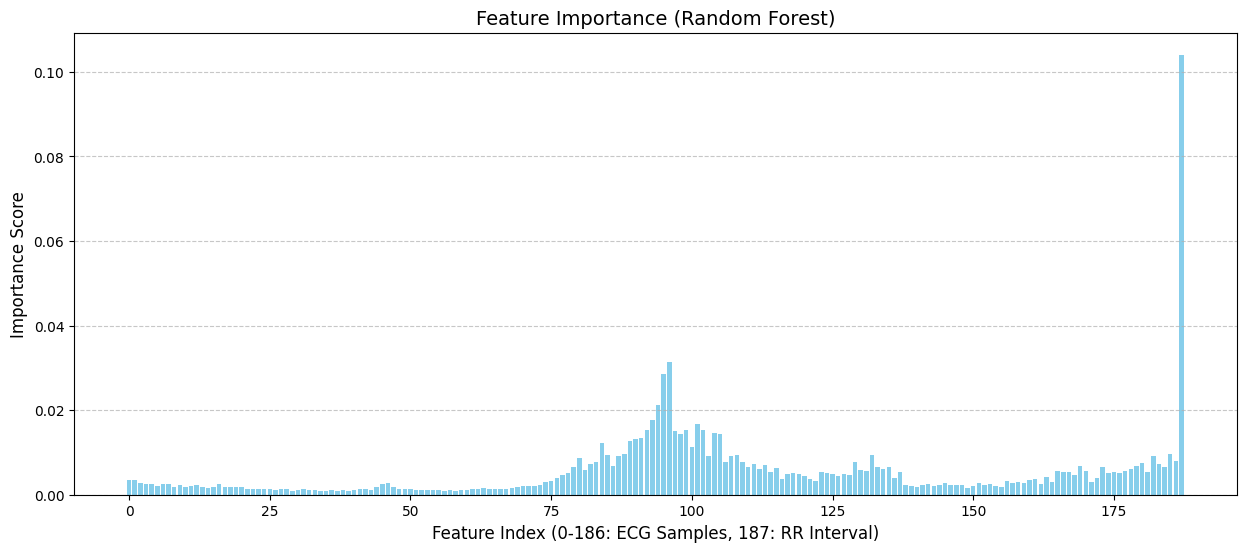

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(feature_importance)), feature_importance, color='skyblue')
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Feature Index (0-186: ECG Samples, 187: RR Interval)', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
top_n = 10
indices = np.argsort(feature_importance)[::-1][:top_n]  # Indices of top N features (descending order)
print(f"Top {top_n} Most Important Features:")
for i, idx in enumerate(indices):
    if idx == 187:
        print(f"{i+1}. Feature {idx} (RR Interval): Importance = {feature_importance[idx]:.4f}")
    else:
        print(f"{i+1}. Feature {idx} (ECG Sample {idx}): Importance = {feature_importance[idx]:.4f}")

Top 10 Most Important Features:
1. Feature 187 (RR Interval): Importance = 0.1041
2. Feature 96 (ECG Sample 96): Importance = 0.0315
3. Feature 95 (ECG Sample 95): Importance = 0.0286
4. Feature 94 (ECG Sample 94): Importance = 0.0213
5. Feature 93 (ECG Sample 93): Importance = 0.0178
6. Feature 101 (ECG Sample 101): Importance = 0.0168
7. Feature 99 (ECG Sample 99): Importance = 0.0153
8. Feature 102 (ECG Sample 102): Importance = 0.0153
9. Feature 92 (ECG Sample 92): Importance = 0.0152
10. Feature 97 (ECG Sample 97): Importance = 0.0152


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Compute class weights based on the original training data (before augmentation)
y_train_labels = np.argmax(y_train, axis=1)  # Use the original y_train to compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
import tensorflow as tf
import numpy as np

# Load the saved CNN model
cnn_model = tf.keras.models.load_model('/content/drive/My Drive/MIT-BIH/saved_model/final_model.h5')
print("CNN model loaded successfully.")

# Load the saved preprocessed data
X_ecg_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy')
X_rr_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_rr_train_aug.npy')
y_train_aug = np.load('/content/drive/My Drive/MIT-BIH/y_train_aug.npy')
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
X_rr_test = np.load('/content/drive/My Drive/MIT-BIH/X_rr_test.npy')
y_test = np.load('/content/drive/My Drive/MIT-BIH/y_test.npy')

# Verify shapes to ensure everything loaded correctly
print("X_ecg_train_aug shape:", X_ecg_train_aug.shape)
print("X_rr_train_aug shape:", X_rr_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)
print("X_ecg_test shape:", X_ecg_test.shape)
print("X_rr_test shape:", X_rr_test.shape)
print("y_test shape:", y_test.shape)

CNN model loaded successfully.
X_ecg_train_aug shape: (101574, 187, 1)
X_rr_train_aug shape: (101574, 1)
y_train_aug shape: (101574, 5)
X_ecg_test shape: (21894, 187, 1)
X_rr_test shape: (21894, 1)
y_test shape: (21894, 5)


In [ ]:
import numpy as np

# Verify data types and shapes
print("X_ecg_train_aug type:", type(X_ecg_train_aug), "shape:", X_ecg_train_aug.shape)
print("X_rr_train_aug type:", type(X_rr_train_aug), "shape:", X_rr_train_aug.shape)
print("y_train_aug type:", type(y_train_aug), "shape:", y_train_aug.shape)
print("X_ecg_test type:", type(X_ecg_test), "shape:", X_ecg_test.shape)
print("X_rr_test type:", type(X_rr_test), "shape:", X_rr_test.shape)
print("y_test type:", type(y_test), "shape:", y_test.shape)

# Ensure all inputs are NumPy arrays
X_ecg_train_aug = np.array(X_ecg_train_aug)
X_rr_train_aug = np.array(X_rr_train_aug)
y_train_aug = np.array(y_train_aug)
X_ecg_test = np.array(X_ecg_test)
X_rr_test = np.array(X_rr_test)
y_test = np.array(y_test)

X_ecg_train_aug type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (101574, 187, 1)
X_rr_train_aug type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (101574, 1)
y_train_aug type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (101574, 5)
X_ecg_test type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (21894, 187, 1)
X_rr_test type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (21894, 1)
y_test type: <class 'tensorflow.python.framework.ops.EagerTensor'> shape: (21894, 5)


In [ ]:
# Convert data to TensorFlow tensors
X_ecg_train_aug = tf.convert_to_tensor(X_ecg_train_aug, dtype=tf.float32)
X_rr_train_aug = tf.convert_to_tensor(X_rr_train_aug, dtype=tf.float32)
y_train_aug = tf.convert_to_tensor(y_train_aug, dtype=tf.float32)
X_ecg_test = tf.convert_to_tensor(X_ecg_test, dtype=tf.float32)
X_rr_test = tf.convert_to_tensor(X_rr_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [ ]:
X_ecg_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy')
X_rr_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_rr_train_aug.npy')
y_train_aug = np.load('/content/drive/My Drive/MIT-BIH/y_train_aug.npy')
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
X_rr_test = np.load('/content/drive/My Drive/MIT-BIH/X_rr_test.npy')
y_test = np.load('/content/drive/My Drive/MIT-BIH/y_test.npy')

In [ ]:
# Verify data types and shapes (should already be NumPy arrays)
print("X_ecg_train_aug type:", type(X_ecg_train_aug), "shape:", X_ecg_train_aug.shape)
print("X_rr_train_aug type:", type(X_rr_train_aug), "shape:", X_rr_train_aug.shape)
print("y_train_aug type:", type(y_train_aug), "shape:", y_train_aug.shape)
print("X_ecg_test type:", type(X_ecg_test), "shape:", X_ecg_test.shape)
print("X_rr_test type:", type(X_rr_test), "shape:", X_rr_test.shape)
print("y_test type:", type(y_test), "shape:", y_test.shape)

X_ecg_train_aug type: <class 'numpy.ndarray'> shape: (101574, 187, 1)
X_rr_train_aug type: <class 'numpy.ndarray'> shape: (101574, 1)
y_train_aug type: <class 'numpy.ndarray'> shape: (101574, 5)
X_ecg_test type: <class 'numpy.ndarray'> shape: (21894, 187, 1)
X_rr_test type: <class 'numpy.ndarray'> shape: (21894, 1)
y_test type: <class 'numpy.ndarray'> shape: (21894, 5)


In [ ]:
# Compute class weights using y_train_aug (fallback)
y_train_aug_labels = np.argmax(y_train_aug, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_aug_labels), y=y_train_aug_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights (using y_train_aug):", class_weight_dict)

Class Weights (using y_train_aug): {0: np.float64(0.2802582567668239), 1: np.float64(2.4698844984802433), 2: np.float64(2.6084745762711865), 3: np.float64(4.3763033175355455), 4: np.float64(2.408964781216649)}


In [ ]:
# Ensure class weights are floats
class_weight_dict = {k: float(v) for k, v in class_weight_dict.items()}
print("Updated Class Weights:", class_weight_dict)

Updated Class Weights: {0: 0.2802582567668239, 1: 2.4698844984802433, 2: 2.6084745762711865, 3: 4.3763033175355455, 4: 2.408964781216649}


In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 830.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully u

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Eager execution enabled:", tf.executing_eagerly())

TensorFlow Version: 2.15.0
Eager execution enabled: True


In [ ]:
X_ecg_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy')
X_rr_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_rr_train_aug.npy')
y_train_aug = np.load('/content/drive/My Drive/MIT-BIH/y_train_aug.npy')
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
X_rr_test = np.load('/content/drive/My Drive/MIT-BIH/X_rr_test.npy')
y_test = np.load('/content/drive/My Drive/MIT-BIH/y_test.npy')

In [ ]:
# Compute class weights using y_train_aug (fallback)
y_train_aug_labels = np.argmax(y_train_aug, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_aug_labels), y=y_train_aug_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights (using y_train_aug):", class_weight_dict)

Class Weights (using y_train_aug): {0: 0.2802582567668239, 1: 2.4698844984802433, 2: 2.6084745762711865, 3: 4.3763033175355455, 4: 2.408964781216649}


In [ ]:
class_weight_dict = {k: float(v) for k, v in class_weight_dict.items()}

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [ ]:
print("Eager execution enabled:", tf.executing_eagerly())

Eager execution enabled: True


In [ ]:
!pip install tensorflow==2.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import tensorflow as tf
import numpy as np
print("TensorFlow Version:", tf.__version__)
print("Eager execution enabled:", tf.executing_eagerly())

TensorFlow Version: 2.18.0
Eager execution enabled: True


In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/My Drive/MIT-BIH/saved_model/final_model.h5')
print("CNN model loaded successfully.")

CNN model loaded successfully.


In [ ]:
X_ecg_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_train_aug.npy')
X_rr_train_aug = np.load('/content/drive/My Drive/MIT-BIH/X_rr_train_aug.npy')
y_train_aug = np.load('/content/drive/My Drive/MIT-BIH/y_train_aug.npy')
X_ecg_test = np.load('/content/drive/My Drive/MIT-BIH/X_ecg_test.npy')
X_rr_test = np.load('/content/drive/My Drive/MIT-BIH/X_rr_test.npy')
y_test = np.load('/content/drive/My Drive/MIT-BIH/y_test.npy')

In [ ]:
print("X_ecg_train_aug type:", type(X_ecg_train_aug), "shape:", X_ecg_train_aug.shape)
print("X_rr_train_aug type:", type(X_rr_train_aug), "shape:", X_rr_train_aug.shape)
print("y_train_aug type:", type(y_train_aug), "shape:", y_train_aug.shape)
print("X_ecg_test type:", type(X_ecg_test), "shape:", X_ecg_test.shape)
print("X_rr_test type:", type(X_rr_test), "shape:", X_rr_test.shape)
print("y_test type:", type(y_test), "shape:", y_test.shape)

X_ecg_train_aug type: <class 'numpy.ndarray'> shape: (101574, 187, 1)
X_rr_train_aug type: <class 'numpy.ndarray'> shape: (101574, 1)
y_train_aug type: <class 'numpy.ndarray'> shape: (101574, 5)
X_ecg_test type: <class 'numpy.ndarray'> shape: (21894, 187, 1)
X_rr_test type: <class 'numpy.ndarray'> shape: (21894, 1)
y_test type: <class 'numpy.ndarray'> shape: (21894, 5)


In [ ]:
y_pred_cnn = cnn_model.predict([X_ecg_test, X_rr_test])
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

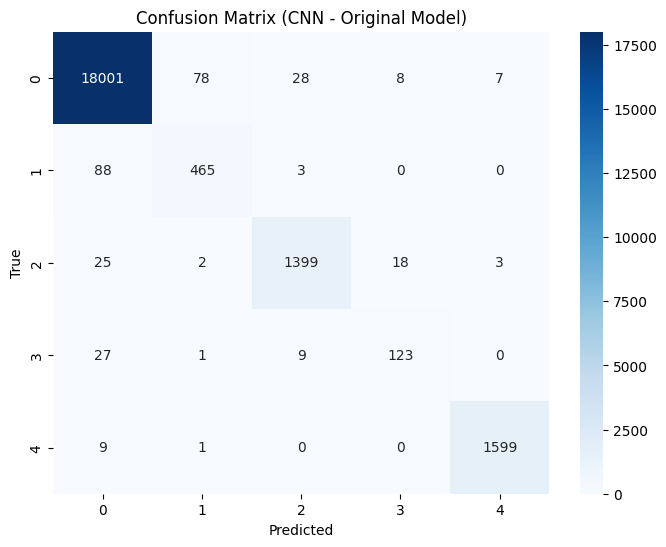

In [ ]:
cm_cnn = confusion_matrix(y_test_classes, y_pred_cnn_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix (CNN - Original Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification Report
print("CNN Classification Report (Original Model):")
print(classification_report(y_test_classes, y_pred_cnn_classes, target_names=['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']))

CNN Classification Report (Original Model):
                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99     18122
Supraventricular       0.85      0.84      0.84       556
     Ventricular       0.97      0.97      0.97      1447
          Fusion       0.83      0.77      0.80       160
         Unknown       0.99      0.99      0.99      1609

        accuracy                           0.99     21894
       macro avg       0.93      0.91      0.92     21894
    weighted avg       0.99      0.99      0.99     21894



In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
rf_model = joblib.load('/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model.pkl')

In [ ]:
# Define feature extraction function (focusing on QRS region)
def extract_features(X_ecg, X_rr):
    features = []
    for i in range(X_ecg.shape[0]):
        ecg = X_ecg[i, :, 0]  # Shape: (187,)
        qrs_region = ecg[75:126]  # Focus on QRS complex (features 75-125)
        feat = [
            np.mean(qrs_region),  # Mean of QRS region
            np.std(qrs_region),   # Std of QRS region
            np.max(qrs_region),   # Max of QRS region
            np.min(qrs_region)    # Min of QRS region
        ]
        feat.append(X_rr[i, 0])  # Add RR interval
        features.append(feat)
    return np.array(features)

In [ ]:
# Apply feature engineering
X_train_rf_features = extract_features(X_ecg_train_aug, X_rr_train_aug)
X_test_rf_features = extract_features(X_ecg_test, X_rr_test)

In [ ]:
# Retrain Random Forest with engineered features
y_train_rf = np.argmax(y_train_aug, axis=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_rf_features, y_train_rf)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Evaluate the updated Random Forest
y_test_classes = np.argmax(y_test, axis=1)
y_pred_rf = rf_model.predict(X_test_rf_features)

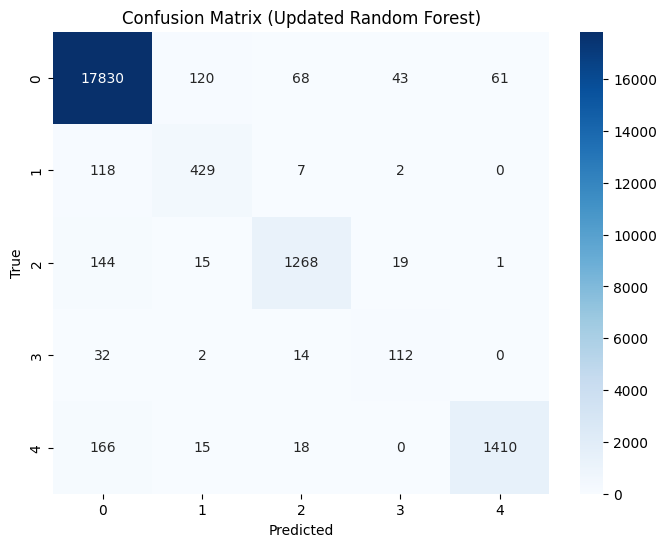

In [ ]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test_classes, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.title('Confusion Matrix (Updated Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification Report
print("Updated Random Forest Classification Report (with QRS-focused features):")
print(classification_report(y_test_classes, y_pred_rf, target_names=['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']))

Updated Random Forest Classification Report (with QRS-focused features):
                  precision    recall  f1-score   support

          Normal       0.97      0.98      0.98     18122
Supraventricular       0.74      0.77      0.75       556
     Ventricular       0.92      0.88      0.90      1447
          Fusion       0.64      0.70      0.67       160
         Unknown       0.96      0.88      0.92      1609

        accuracy                           0.96     21894
       macro avg       0.85      0.84      0.84     21894
    weighted avg       0.96      0.96      0.96     21894



In [ ]:
# Save the updated Random Forest model
joblib.dump(rf_model, '/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model_updated.pkl')

['/content/drive/My Drive/MIT-BIH/saved_model/random_forest_model_updated.pkl']